# Linear least squares

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkplot.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import thinkplot

<IPython.core.display.Javascript object>

## Least squares fit

Correlation coefficients measure the strength and sign of a
relationship, but not the slope. There are several ways to estimate the
slope; the most common is a **linear least squares fit**. A "linear fit"
is a line intended to model the relationship between variables. A "least
squares" fit is one that minimizes the mean squared error (MSE) between
the line and the data.

Suppose we have a sequence of points, `ys`, that we want to express as a
function of another sequence `xs`. If there is a linear relationship
between `xs` and `ys` with intercept `inter` and slope `slope`, we
expect each `y[i]` to be `inter + slope * x[i]`.

But unless the correlation is perfect, this prediction is only
approximate. The vertical deviation from the line, or **residual**, is

The residuals might be due to random factors like measurement error, or
non-random factors that are unknown. For example, if we are trying to
predict weight as a function of height, unknown factors might include
diet, exercise, and body type.

If we get the parameters `inter` and `slope` wrong, the residuals get
bigger, so it makes intuitive sense that the parameters we want are the
ones that minimize the residuals.

We might try to minimize the absolute value of the residuals, or their
squares, or their cubes; but the most common choice is to minimize the
sum of squared residuals, `sum(res**2)`.

Why? There are three good reasons and one less important one:

-   Squaring has the feature of treating positive and negative residuals
    the same, which is usually what we want.

-   Squaring gives more weight to large residuals, but not so much
    weight that the largest residual always dominates.

-   If the residuals are uncorrelated and normally distributed with mean
    0 and constant (but unknown) variance, then the least squares fit is
    also the maximum likelihood estimator of `inter` and `slope`. See
    <https://en.wikipedia.org/wiki/Linear_regression>.

-   The values of `inter` and `slope` that minimize the squared
    residuals can be computed efficiently.

The last reason made sense when computational efficiency was more
important than choosing the method most appropriate to the problem at
hand. That's no longer the case, so it is worth considering whether
squared residuals are the right thing to minimize.

For example, if you are using `xs` to predict values of `ys`, guessing
too high might be better (or worse) than guessing too low. In that case
you might want to compute some cost function for each residual, and
minimize total cost, `sum(cost(res))`. However, computing a least
squares fit is quick, easy and often good enough.

## Implementation

TODO: Explain how to compute slope and inter

The following function takes `xs` and `ys` and returns the intercept and slope of the best fit line.

In [4]:
from thinkstats import mean, var, std, cov


def least_squares(xs, ys):
    xbar = mean(xs)
    ybar = mean(ys)
    slope = cov(xs, ys) / var(xs)
    inter = ybar - slope * xbar
    return inter, slope

<IPython.core.display.Javascript object>

`least_squares` takes sequences `xs` and `ys` and returns the estimated
parameters `inter` and `slope`.

We can use these functions to compute the least squares fit for birth
weight as a function of mother's age.

In [5]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [6]:
import nsfg

live, firsts, others = nsfg.make_frames()
live = live.dropna(subset=["agepreg", "totalwgt_lb"])
ages = live.agepreg
weights = live.totalwgt_lb

<IPython.core.display.Javascript object>

In [7]:
inter, slope = least_squares(ages, weights)
inter, slope

(6.8303969733110526, 0.01745385147180276)

<IPython.core.display.Javascript object>

The estimated intercept and slope are 6.8 lbs and 0.017 lbs per year.
These values are hard to interpret in this form: the intercept is the
expected weight of a baby whose mother is 0 years old, which doesn't
make sense in context, and the slope is too small to grasp easily.

Instead of presenting the intercept at $x=0$, it is often helpful to
present the intercept at the mean of $x$. In this case the mean age is
about 25 years and the mean baby weight for a 25 year old mother is 7.3
pounds. 

In [8]:
x = 25
inter + x * slope

7.2667432601061215

<IPython.core.display.Javascript object>

The following function computes the fitted line for a sequence of `xs` and the given intercept and slope.

In [9]:
def predict(xs, inter, slope):
    xs = np.asarray(xs)
    return inter + slope * xs

<IPython.core.display.Javascript object>

In [10]:
def fit_line(xs, inter, slope):
    low, high = min(xs), max(xs)
    fit_xs = np.linspace(low, high)
    fit_ys = predict(fit_xs, inter, slope)
    return fit_xs, fit_ys

<IPython.core.display.Javascript object>

In [11]:
fit_xs, fit_ys = fit_line(ages, inter, slope)

<IPython.core.display.Javascript object>

Now we can plot the fitted line on top of a scatter plot of the data.

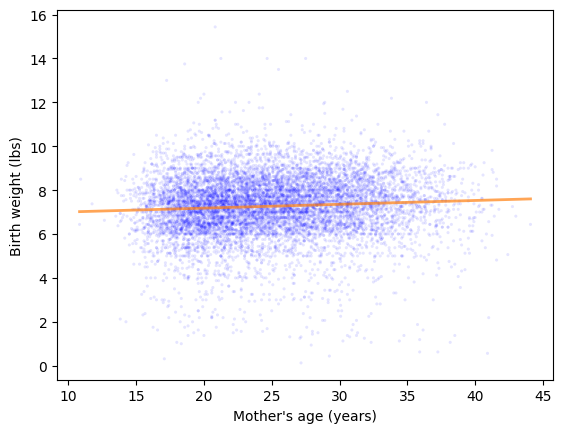

<IPython.core.display.Javascript object>

In [12]:
thinkplot.scatter(ages, weights, alpha=0.1, s=5)
thinkplot.plot(fit_xs, fit_ys, color="C1", linewidth=2)
thinkplot.config(
    xlabel="Mother's age (years)",
    ylabel="Birth weight (lbs)",
)

It's a good idea to look at a figure like this to assess whether the
relationship is linear and whether the fitted line seems like a good
model of the relationship.

## Residuals

Another useful test is to plot the residuals.

TODO: definition

The following function computes residuals:

In [13]:
def residuals(xs, ys, inter, slope):
    fit_ys = predict(xs, inter, slope)
    return ys - fit_ys

<IPython.core.display.Javascript object>

`residuals` takes sequences `xs` and `ys` and estimated parameters
`inter` and `slope`. It returns the differences between the actual
values and the fitted line.

In [14]:
live["residual"] = residuals(ages, weights, inter, slope)

<IPython.core.display.Javascript object>

In [15]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)
age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333335,
 17.740359281437126,
 20.506304824561404,
 23.455752212389378,
 26.435156146179406,
 29.411177432542924,
 32.30232530120482,
 35.240273631840786,
 38.10876470588235,
 40.91205882352941]

<IPython.core.display.Javascript object>

To visualize the residuals, I group respondents by age and compute
percentiles in each group. The following figure
shows the 25th, 50th and 75th percentiles of the residuals for each age
group. 

In [16]:
from thinkstats import Cdf

# TODO: Do this with a simpler version of percentile

cdfs = [Cdf(group.residual) for _, group in groups][1:-1]

<IPython.core.display.Javascript object>

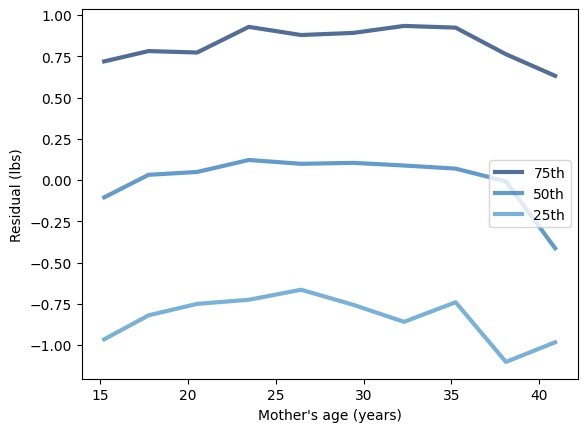

<IPython.core.display.Javascript object>

In [17]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.percentile(percent) for cdf in cdfs]
    label = "%dth" % percent
    thinkplot.plot(age_means, weight_percentiles, label=label)

thinkplot.config(xlabel="Mother's age (years)", ylabel="Residual (lbs)")

The median is near zero, as expected, and the interquartile range
is about 2 pounds. So if we know the mother's age, we can guess the
baby's weight within a pound, about 50% of the time.

Ideally these lines should be flat, indicating that the residuals are
random, and parallel, indicating that the variance of the residuals is
the same for all age groups. In fact, the lines are close to parallel,
so that's good; but they have some curvature, indicating that the
relationship is nonlinear. Nevertheless, the linear fit is a simple
model that is probably good enough for some purposes.

## Estimation

The parameters `slope` and `inter` are estimates based on a sample; like
other estimates, they are vulnerable to sampling bias, measurement
error, and sampling error. 

Sampling bias is caused by non-representative
sampling, measurement error is caused by errors in collecting and
recording data, and sampling error is the result of measuring a sample
rather than the entire population.

To assess sampling error, we ask, "If we run this experiment again, how
much variability do we expect in the estimates?" We can answer this
question by running simulated experiments and computing sampling
distributions of the estimates.

We can simulate the experiments by resampling the data; that is, by treating the
observed pregnancies as if they were the entire population and drawing
samples, with replacement, from the observed sample.

In [18]:
def resample_rows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    n = len(df)
    return df.sample(n, replace=True)

<IPython.core.display.Javascript object>

In [19]:
def sampling_distributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = resample_rows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = least_squares(ages, weights)
        t.append(estimates)
    inters, slopes = zip(*t)
    return inters, slopes

<IPython.core.display.Javascript object>

In [20]:
inters, slopes = sampling_distributions(live, iters=1001)

<IPython.core.display.Javascript object>

`SamplingDistributions` takes a DataFrame with one row per live birth,
and `iters`, the number of experiments to simulate. It uses
`ResampleRows` to resample the observed pregnancies. We've already seen
`SampleRows`, which chooses random rows from a DataFrame. `thinkstats2`
also provides `ResampleRows`, which returns a sample the same size as
the original:

After resampling, we use the simulated sample to estimate parameters.
The result is two sequences: the estimated intercepts and estimated
slopes.

I summarize the sampling distributions by printing the standard error
and confidence interval:

In [21]:
def summarize(estimates, actual=None):
    se = std(estimates)
    cdf = Cdf(estimates)
    ci = cdf.confidence_interval(90)
    print(se, ci)

<IPython.core.display.Javascript object>

`Summarize` takes a sequence of estimates and the actual value. It
prints the mean of the estimates, the standard error and a 90%
confidence interval.

In [22]:
summarize(inters)

0.06825423305914483 (6.724753362468019, 6.944239216975048)


<IPython.core.display.Javascript object>

In [23]:
summarize(slopes)

0.00272301046013431 (0.013030581065383535, 0.02183780099107707)


<IPython.core.display.Javascript object>

For the intercept, the standard error is 0.071
and 90% confidence interval (6.71, 6.94).
For the slope, the standard error is 0.0174, and 90% CI (0.0126, 0.0220).
There is almost
a factor of two between the low and high ends of this CI, so it should
be considered a rough estimate.

To visualize the sampling error of the estimate, we can plot all of the fitted lines.

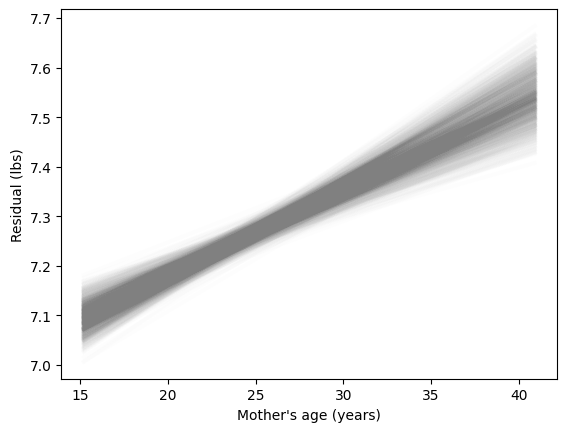

<IPython.core.display.Javascript object>

In [24]:
for slope, inter in zip(slopes, inters):
    fxs, fys = fit_line(age_means, inter, slope)
    thinkplot.plot(fxs, fys, color="gray", alpha=0.01)

thinkplot.config(xlabel="Mother's age (years)", ylabel="Residual (lbs)")

Or for a less cluttered representation, we can plot a 90%
confidence interval for each age. Here's the code:

In [25]:
from thinkstats import percentile_rows


def plot_confidence_intervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = fit_line(xs, inter, slope)
        fys_seq.append(fys)
    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = percentile_rows(fys_seq, percents)
    thinkplot.fill_between(fxs, low, high, **options)

<IPython.core.display.Javascript object>

`xs` is the sequence of mother's age. `inters` and `slopes` are the
estimated parameters generated by `sampling_distributions`. `percent`
indicates which confidence interval to plot.

`plot_confidence_intervals` generates a fitted line for each pair of
`inter` and `slope` and stores the results in a sequence, `fys_seq`.
Then it uses `percentile_rows` to select the upper and lower percentiles
of `y` for each value of `x`. For a 90% confidence interval, it selects
the 5th and 95th percentiles. `fill_between` draws a polygon that fills
the space between two lines.

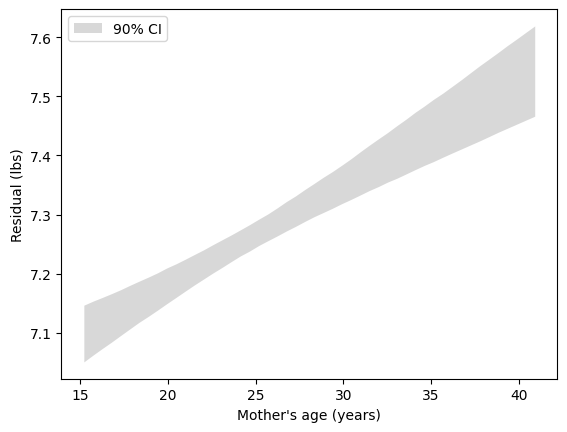

<IPython.core.display.Javascript object>

In [26]:
plot_confidence_intervals(
    age_means, inters, slopes, percent=90, color="gray", alpha=0.3, label="90% CI"
)
thinkplot.config(xlabel="Mother's age (years)", ylabel="Residual (lbs)")

The vertical width of the region
represents the effect of sampling error -- the effect is smaller for
values near the mean and larger for the extremes.

## Goodness of fit

There are several ways to measure the quality of a linear model, or
**goodness of fit**. One of the simplest is the standard deviation of
the residuals.

If you use a linear model to make predictions, `std(res)` is the root
mean squared error (RMSE) of your predictions. For example, if you use
mother's age to guess birth weight, the RMSE of your guess would be 1.40
lbs.

In [27]:
inter, slope = least_squares(ages, weights)
res = residuals(ages, weights, inter, slope)

<IPython.core.display.Javascript object>

In [28]:
print("Std(ys)", std(weights))
print("Std(res)", std(res))

Std(ys) 1.40821553384062
Std(res) 1.4048754287857832


<IPython.core.display.Javascript object>

If you guess birth weight without knowing the mother's age, the RMSE of
your guess is `Std(ys)`, which is 1.41 lbs. So in this example, knowing
a mother's age does not improve the predictions substantially.

Another way to measure goodness of fit is the **coefficient of
determination**, usually denoted $R^2$ and called "R-squared":

In [29]:
def coef_determination(ys, res):
    return 1 - var(res) / var(ys)

<IPython.core.display.Javascript object>

In [30]:
r2 = coef_determination(weights, res)
r2

0.00473811547471048

<IPython.core.display.Javascript object>

In [31]:
from thinkstats import corr

print("rho", corr(ages, weights))
print("R", np.sqrt(r2))

rho 0.0688339703541091
R 0.0688339703541099


<IPython.core.display.Javascript object>

`Var(res)` is the MSE of your guesses using the model, `Var(ys)` is the
MSE without it. So their ratio is the fraction of MSE that remains if
you use the model, and $R^2$ is the fraction of MSE the model
eliminates.

For birth weight and mother's age, $R^2$ is 0.0047, which means that
mother's age predicts about half of 1% of variance in birth weight.

There is a simple relationship between the coefficient of determination
and Pearson's coefficient of correlation: $R^2 = \rho^2$. For example,
if $\rho$ is 0.8 or -0.8, $R^2 = 0.64$.

Although $\rho$ and $R^2$ are often used to quantify the strength of a
relationship, they are not easy to interpret in terms of predictive
power. In my opinion, `Std(res)` is the best representation of the
quality of prediction, especially if it is presented in relation to
`Std(ys)`.

For example, when people talk about the validity of the SAT (a
standardized test used for college admission in the U.S.) they often
talk about correlations between SAT scores and other measures of
intelligence.

According to one study, there is a Pearson correlation of $\rho=0.72$
between total SAT scores and IQ scores, which sounds like a strong
correlation. But $R^2 = \rho^2 = 0.52$, so SAT scores account for only
52% of variance in IQ.

IQ scores are normalized with `Std(ys) = 15`, so

In [32]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

<IPython.core.display.Javascript object>

So using SAT score to predict IQ reduces RMSE from 15 points to 10.4
points. A correlation of 0.72 yields a reduction in RMSE of only 31%.

If you see a correlation that looks impressive, remember that $R^2$ is a
better indicator of reduction in MSE, and reduction in RMSE is a better
indicator of predictive power.

## Testing a linear model

The effect of mother's age on birth weight is small, and has little
predictive power. So is it possible that the apparent relationship is
due to chance? There are several ways we might test the results of a
linear fit.

One option is to test whether the apparent reduction in MSE is due to
chance. In that case, the test statistic is $R^2$ and the null
hypothesis is that there is no relationship between the variables. We
can simulate the null hypothesis by permutation.

In fact, because $R^2 = \rho^2$, a one-sided test
of $R^2$ is equivalent to a two-sided test of $\rho$. We've already done
that test, and found $p < 0.001$, so we conclude that the apparent
relationship between mother's age and birth weight is statistically
significant.

Another approach is to test whether the apparent slope is due to chance.
The null hypothesis is that the slope is actually zero; in that case we
can model the birth weights as random variations around their mean.
Here's a HypothesisTest for this model:

In [33]:
from thinkstats import HypothesisTest


class SlopeTest(HypothesisTest):

    def test_statistic(self, data):
        ages, weights = data
        _, slope = least_squares(ages, weights)
        return slope

    def make_model(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def run_model(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

<IPython.core.display.Javascript object>

The data are represented as sequences of ages and weights. The test
statistic is the slope estimated by `LeastSquares`. The model of the
null hypothesis is represented by the mean weight of all babies and the
deviations from the mean. To generate simulated data, we permute the
deviations and add them to the mean.

Here's the code that runs the hypothesis test:

In [34]:
live = live.dropna(subset=["agepreg", "totalwgt_lb"])
ht = SlopeTest((live.agepreg, live.totalwgt_lb))
p_value = ht.p_value()
p_value

0.0

<IPython.core.display.Javascript object>

In [35]:
ht.actual, max(ht.test_stats)

(0.01745385147180276, 0.006488860059865878)

<IPython.core.display.Javascript object>

The p-value is less than $0.001$, so although the estimated slope is
small, it is unlikely to be due to chance.

Estimating the p-value by simulating the null hypothesis is strictly
correct, but there is a simpler alternative. 

## Weighted resampling

So far we have treated the NSFG data as if it were a representative
sample, but as I mentioned in
Section [\[nsfg\]](#nsfg){reference-type="ref" reference="nsfg"}, it is
not. The survey deliberately oversamples several groups in order to
improve the chance of getting statistically significant results; that
is, in order to improve the power of tests involving these groups.

This survey design is useful for many purposes, but it means that we
cannot use the sample to estimate values for the general population
without accounting for the sampling process.

For each respondent, the NSFG data includes a variable called
`finalwgt`, which is the number of people in the general population the
respondent represents. This value is called a **sampling weight**, or
just "weight."

As an example, if you survey 100,000 people in a country of 300 million,
each respondent represents 3,000 people. If you oversample one group by
a factor of 2, each person in the oversampled group would have a lower
weight, about 1500.

To correct for oversampling, we can use resampling; that is, we can draw
samples from the survey using probabilities proportional to sampling
weights. Then, for any quantity we want to estimate, we can generate
sampling distributions, standard errors, and confidence intervals. As an
example, I will estimate mean birth weight with and without sampling
weights.

In Section [\[regest\]](#regest){reference-type="ref"
reference="regest"}, we saw `ResampleRows`, which chooses rows from a
DataFrame, giving each row the same probability. Now we need to do the
same thing using probabilities proportional to sampling weights.
`ResampleRowsWeighted` takes a DataFrame, resamples rows according to
the weights in `finalwgt`, and returns a DataFrame containing the
resampled rows:

In [36]:
def resample_rows_weighted(df, column="finalwgt"):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    n = len(df)
    weights = df[column]
    return df.sample(n, weights=weights, replace=True)

<IPython.core.display.Javascript object>

`weights` is a Series; converting it to a dictionary makes a map from
the indices to the weights. In `cdf` the values are indices and the
probabilities are proportional to the weights.

`indices` is a sequence of row indices; `sample` is a DataFrame that
contains the selected rows. Since we sample with replacement, the same
row might appear more than once.

Now we can compare the effect of resampling with and without weights.
Without weights, we generate the sampling distribution like this:

In [37]:
iters = 100
estimates = [resample_rows_weighted(live).totalwgt_lb.mean() for _ in range(iters)]
summarize(estimates)

0.013243078139489824 (7.32879923655676, 7.368845430404956)


<IPython.core.display.Javascript object>

With weights, it looks like this:

In [38]:
estimates = [resample_rows(live).totalwgt_lb.mean() for _ in range(iters)]
summarize(estimates)

0.013513642651443622 (7.242773567160876, 7.28455548793981)


<IPython.core.display.Javascript object>

The following table summarizes the results:

TODO: recompute this table, replacing the means of the sampling distributions with the actual estimates

 ```
  ------------ -------------- ---------- --------------
                 mean birth    standard      90% CI
                weight (lbs)    error    
  Unweighted        7.27        0.014     (7.24, 7.29)
  Weighted          7.35        0.014     (7.32, 7.37)
  ------------ -------------- ---------- --------------
```

In this example, the effect of weighting is small but non-negligible.
The difference in estimated means, with and without weighting, is about
0.08 pounds, or 1.3 ounces. This difference is substantially larger than
the standard error of the estimate, 0.014 pounds, which implies that the
difference is not due to chance.

## Glossary

-   **linear fit**: a line intended to model the relationship between
    variables.

-   **least squares fit**: A model of a dataset that minimizes the sum
    of squares of the residuals.

-   **residual**: The deviation of an actual value from a model.

-   **goodness of fit**: A measure of how well a model fits data.

-   **coefficient of determination**: A statistic intended to quantify
    goodness of fit.

-   **sampling weight**: A value associated with an observation in a
    sample that indicates what part of the population it represents.

# Exercises

**Exercise:** Use `resample_rows` and generate a list of estimates for the mean birth weight.  Use `summarize` to compute the SE and CI for these estimates.

In [39]:
iters = 1000
estimates = [resample_rows(live).totalwgt_lb.mean() for _ in range(iters)]
summarize(estimates)

0.014821022499759017 (7.241819263111307, 7.291201040053109)


<IPython.core.display.Javascript object>

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [40]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/brfss.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

<IPython.core.display.Javascript object>

In [41]:
import brfss

df = brfss.read_brfss()

<IPython.core.display.Javascript object>

In [42]:
df = df.dropna(subset=["htm3", "wtkg2"])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

<IPython.core.display.Javascript object>

Estimate intercept and slope.

In [43]:
inter, slope = least_squares(heights, log_weights)
inter, slope

(0.9930804163932889, 0.005281454169417769)

<IPython.core.display.Javascript object>

Make a scatter plot of the data and show the fitted line.

In [44]:
fxs, fys = fit_line(heights, inter, slope)

<IPython.core.display.Javascript object>

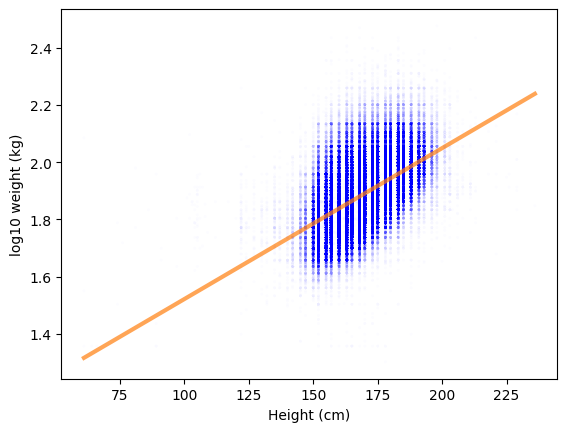

<IPython.core.display.Javascript object>

In [47]:
thinkplot.scatter(heights, log_weights, alpha=0.01, s=5)
thinkplot.plot(fxs, fys, color="C1")
thinkplot.config(xlabel="Height (cm)", ylabel="log10 weight (kg)")

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

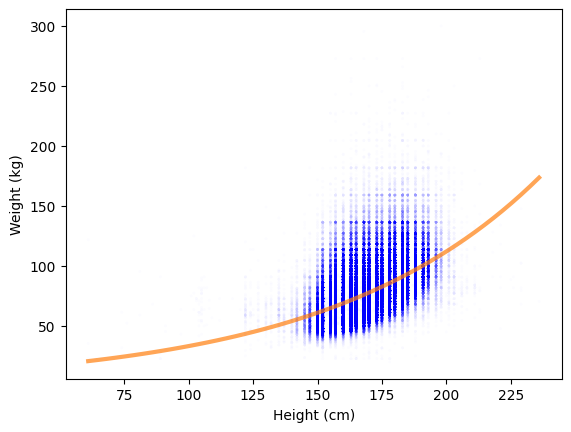

<IPython.core.display.Javascript object>

In [48]:
thinkplot.scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = fit_line(heights, inter, slope)
thinkplot.plot(fxs, 10**fys, color="C1")
thinkplot.config(xlabel="Height (cm)", ylabel="Weight (kg)", legend=False)

Plot percentiles of the residuals.

In [49]:
res = residuals(heights, log_weights, inter, slope)
df["residual"] = res

<IPython.core.display.Javascript object>

In [50]:
bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)
means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [Cdf(group.residual) for i, group in groups][1:-1]

<IPython.core.display.Javascript object>

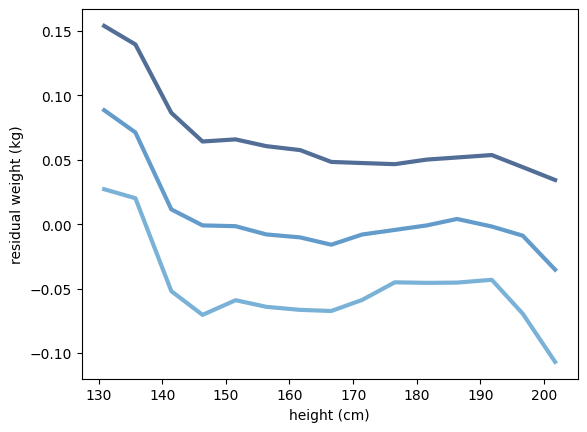

<IPython.core.display.Javascript object>

In [51]:
for percent in [75, 50, 25]:
    ys = [cdf.percentile(percent) for cdf in cdfs]
    label = "%dth" % percent
    thinkplot.plot(means, ys, label=label)

thinkplot.config(xlabel="height (cm)", ylabel="residual weight (kg)")

Compute correlation.

In [52]:
rho = corr(heights, log_weights)
rho

0.5317282605983424

<IPython.core.display.Javascript object>

Compute coefficient of determination.

In [53]:
r2 = coef_determination(log_weights, res)
r2

0.28273494311893954

<IPython.core.display.Javascript object>

Confirm that $R^2 = \rho^2$.

In [54]:
np.isclose(rho**2, r2)

True

<IPython.core.display.Javascript object>

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [55]:
std_ys = std(log_weights)
std_ys

0.1032072503000489

<IPython.core.display.Javascript object>

Compute Std(res), the RMSE of predictions that do use height.

In [56]:
std_res = std(res)
std_res

0.08740777080416089

<IPython.core.display.Javascript object>

How much does height information reduce RMSE?

In [57]:
1 - std_res / std_ys

0.15308497658793385

<IPython.core.display.Javascript object>

Use resampling to compute sampling distributions for inter and slope.

In [58]:
t = []
for _ in range(100):
    sample = resample_rows(df)
    estimates = least_squares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)
inters, slopes = zip(*t)

<IPython.core.display.Javascript object>

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

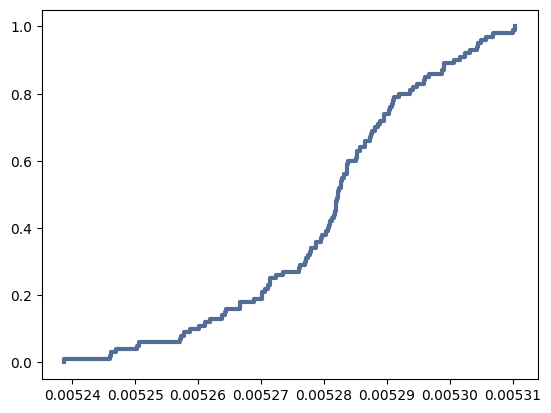

<IPython.core.display.Javascript object>

In [59]:
cdf = Cdf(slopes)
thinkplot.cdf(cdf)

Compute the p-value of the slope.

In [60]:
pvalue = cdf[0]
pvalue

0

<IPython.core.display.Javascript object>

Compute the 90% confidence interval of slope.

In [61]:
ci = cdf.percentile(5), cdf.percentile(95)
ci

(0.0052502348530310775, 0.005304472375087509)

<IPython.core.display.Javascript object>

Compute the standard deviation of the sampling distribution, which is the standard error.

In [62]:
stderr = std(slopes)
stderr

1.509207630022443e-05

<IPython.core.display.Javascript object>

Resample rows without weights, compute mean height, and summarize results.

In [63]:
estimates_unweighted = [resample_rows(df).htm3.mean() for _ in range(100)]
summarize(estimates_unweighted)

0.016914422601515107 (168.9282069160654, 168.98149467450838)


<IPython.core.display.Javascript object>

Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [64]:
estimates_weighted = [
    resample_rows_weighted(df, "finalwt").htm3.mean() for _ in range(100)
]
summarize(estimates_weighted)

0.019136840868720053 (170.46358050890277, 170.5277365144809)


<IPython.core.display.Javascript object>